In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from keras.datasets import mnist, fashion_mnist
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load data.
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize data.
x_test = x_test / np.max(x_train)
x_train = x_train / np.max(x_train)

# Add input channel dimension.
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

In [3]:
x_train.shape

(60000, 28, 28, 1)

# Architecture breakdown

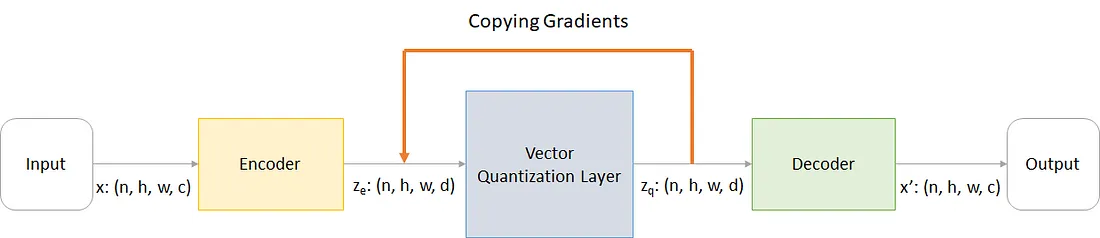

# Defining our Code Blocks

In [4]:
''' 1. Our Mnist input of shape (60000, 28, 28, 1) is first passed through an encoder block for feature extraction. '''

encoder = tf.keras.Sequential([
layers.Conv2D(16, kernel_size=4, strides=2, padding='same', input_shape=(28,28, 1)),
layers.BatchNormalization(),
layers.ReLU(),
layers.Conv2D(4, kernel_size=4, strides=2, padding='same'),
layers.BatchNormalization(),
layers.ReLU(),
])

''' 2.  The extracted features gets further passed through a pre quant convolution to get desired shape  (60000, 28, 28, D),
         where D is equivalent to the Embedding dimension of our CODE BOOK. '''

pre_quant_conv = layers.Conv2D(2, kernel_size=1)

''' 3.  Lets define our embedding code book vector of total 3 embeddings each of dimension 2. And then initialise some random values(weights to it)'''

embedding = layers.Embedding(3,2)
_ = embedding(tf.constant([[0, 1, 2]]))

''' 4.  after feature extracteion from image gets passed through vector quantize layer  we pass it through post quant convolution for change in last dimension '''

post_quant_conv = layers.Conv2D(4, kernel_size=1)

# Commitment Loss Beta
beta = 0.2

''' 5. Finally the we get ouput image from the Decoder '''

decoder = tf.keras.Sequential([
layers.Conv2DTranspose(16, kernel_size=4, strides=2, padding='same'),
layers.BatchNormalization(),
layers.ReLU(),
layers.Conv2DTranspose(1, kernel_size=4, strides=2, padding='same'),
layers.Activation('tanh')
])

2024-04-18 10:16:07.025304: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-04-18 10:16:07.025323: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2024-04-18 10:16:07.025327: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2024-04-18 10:16:07.025358: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-18 10:16:07.025372: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Architecture of our Vector quantization layer

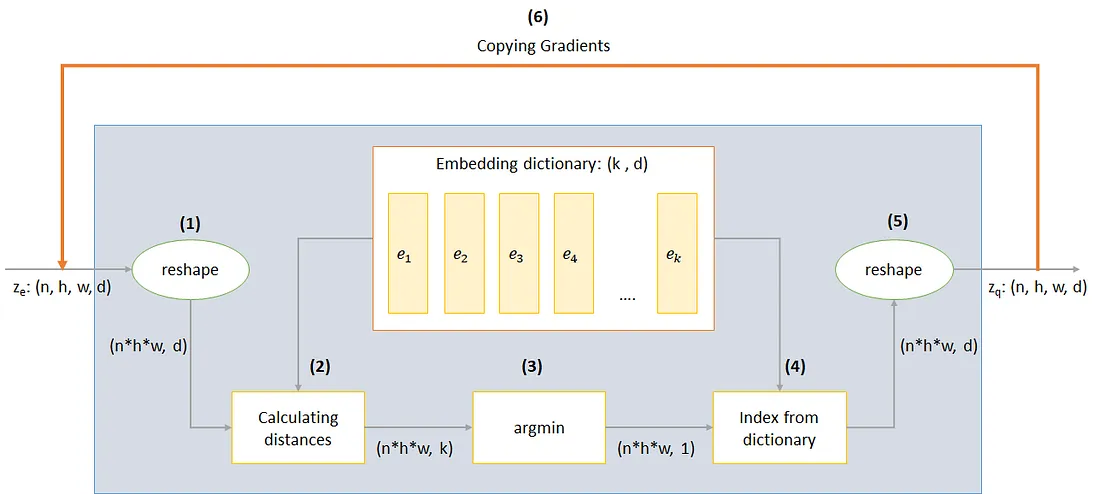

# The Forward Process 

1. Pass the input through encoder and then pre quant conv layer to get desired H*W*C

In [5]:
x = tf.random.normal(shape=(60, 28, 28, 1))
encoded_output = encoder(x)
quant_input = pre_quant_conv(encoded_output)
quant_input.shape

TensorShape([60, 7, 7, 2])

2. Reshape the feature input to  (B*H*W, C) ---> (60 * 7 * 7,2)  where 2 represents the same dimension embedding as our code book vector.

In [6]:
B,H, W,C = quant_input.shape
quant_input = tf.reshape(quant_input, (B*H*W, C))

3. Now find the nearest code book embedding for each (B * H * W) input with our code book embedding (3*2). Replace the nearest embedding vector of dimension 2 with our feature input.

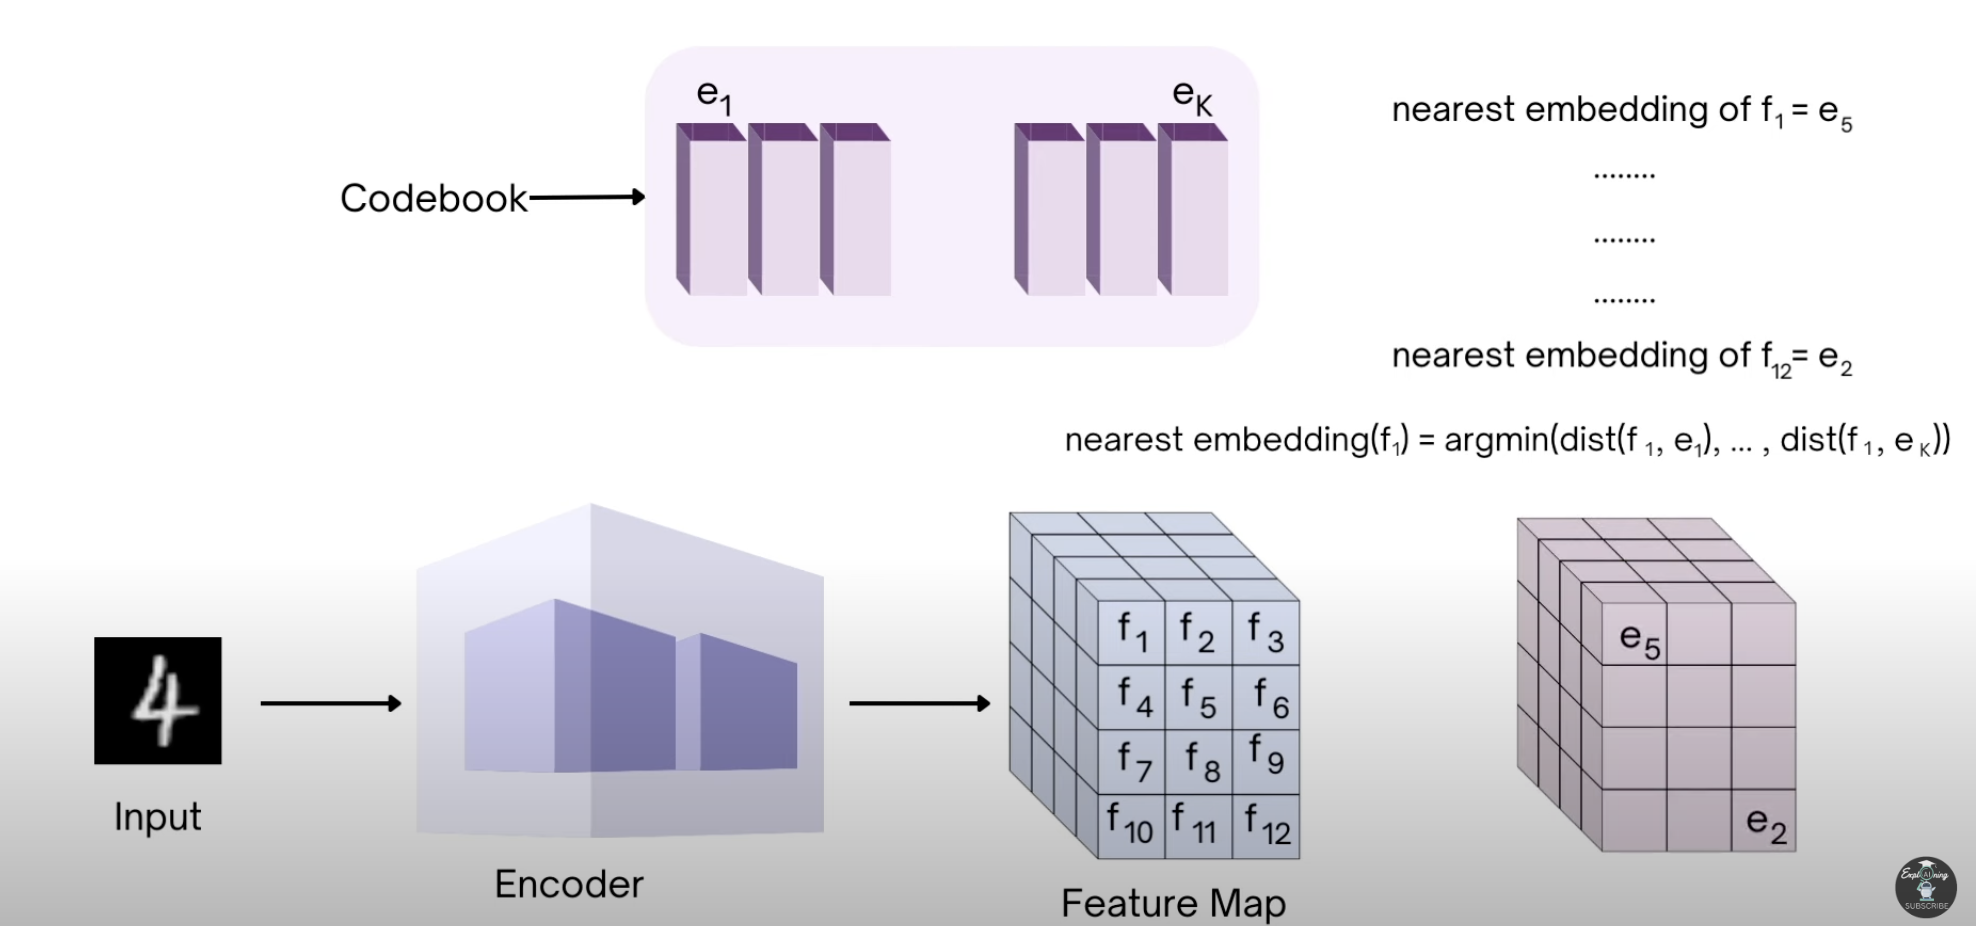

In [7]:
dist = tf.norm(tf.expand_dims(quant_input, axis=1) - tf.expand_dims(embedding.weights[0], axis=0), axis=-1)
quant_output = tf.gather(embedding.weights[0], tf.argmin(dist,axis=1))

# Losses

1. **Commitment Loss (`commitment_loss`)**: This loss is calculated as the mean squared difference between the output of the quantization layer (`quant_output`) and the input to the quantization layer (`quant_input`). The `tf.stop_gradient` function is used to prevent the gradients from flowing into the `quant_input`.

2. **Codebook Loss (`codebook_loss`)**: This loss is calculated as the mean squared difference between the output of the quantization layer (`quant_output`) and the input to the quantization layer (`quant_input`). The `tf.stop_gradient` function is used to prevent the gradients from flowing into the `quant_output`.

3. **Quantization Losses (`quantize_losses`)**: This is the total loss for the quantization layer. It's calculated as the sum of the `codebook_loss` and the `commitment_loss` scaled by a factor `beta`.

4. **Quantization Output (`quant_output`)**: This is the final output of the quantization layer. It's calculated as the input to the quantization layer (`quant_input`) plus the difference between the output of the quantization layer (`quant_output`) and the input to the quantization layer (`quant_input`), where the difference is stopped from backpropagation using `tf.stop_gradient`.

These losses are typically used in Vector Quantized Variational AutoEncoders (VQ-VAE), where the `commitment_loss` ensures that the encoder commits to the discrete latent representations in the codebook, and the `codebook_loss` ensures that the codebook adapts to the encoder's representations. The `quantize_losses` is the total loss that is minimized during training. The `quant_output` is the final output of the quantization layer that is used for further processing or decoding.

In [8]:
commitment_loss = tf.reduce_mean(tf.square(tf.stop_gradient(quant_output) - quant_input))
codebook_loss = tf.reduce_mean(tf.square(quant_output-tf.stop_gradient(quant_input)))

quantize_losses = codebook_loss + beta*commitment_loss

# reconstruction_loss = tf.reduce_mean(tf.square(data - output))
# total_loss = reconstruction_loss + quantize_losses

5.  finally pass through our post conv and encoder block

In [9]:
quant_output = quant_input + tf.stop_gradient(quant_output - quant_input)
quant_output = tf.reshape(quant_output, (B, H, W, C))

decoder_input = post_quant_conv(quant_output)
output = decoder(decoder_input)

output.shape

TensorShape([60, 28, 28, 1])

# Putting our entire code in one block and executing it

In [10]:
# Load and preprocess the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Define the VQ-VAE model
class VQVAE(tf.keras.Model):
    def __init__(self):
        super(VQVAE, self).__init__()
        
        self.encoder = tf.keras.Sequential([
            layers.Conv2D(16, kernel_size=4, strides=2, padding='same', input_shape=(28,28, 1)),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2D(8, kernel_size=4, strides=2, padding='same'),
            layers.BatchNormalization(),
            layers.ReLU(),
        ])

        self.pre_quant_conv = layers.Conv2D(4, kernel_size=1)

        self.embedding = layers.Embedding(10,4)     # I chose 10 vectors each of dimension 4 because 10 digits in mnist.
        _ = self.embedding(tf.constant([[0, 1, 2,3]]))

        self.post_quant_conv = layers.Conv2D(4, kernel_size=1)

        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(16, kernel_size=4, strides=2, padding='same'),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2DTranspose(1, kernel_size=4, strides=2, padding='same'),
            layers.Activation('tanh')
        ])

    def call(self, x,y=None):
        encoded_output = self.encoder(x)
        quant_input = self.pre_quant_conv(encoded_output)

        B,H, W,C = quant_input.shape
        quant_input = tf.reshape(quant_input, (B*H*W, C))

        dist = tf.norm(tf.expand_dims(quant_input, axis=1) - tf.expand_dims(self.embedding.weights[0], axis=0), axis=-1)
        quant_output = tf.gather(self.embedding.weights[0], tf.argmin(dist,axis=1))

        commitment_loss = tf.reduce_mean(tf.square(tf.stop_gradient(quant_output) - quant_input))
        codebook_loss = tf.reduce_mean(tf.square(quant_output-tf.stop_gradient(quant_input)))

        quantize_losses = codebook_loss + beta*commitment_loss

        quant_output = quant_input + tf.stop_gradient(quant_output - quant_input)
        quant_output = tf.reshape(quant_output, (B, H, W, C))

        decoder_input = self.post_quant_conv(quant_output)
        output = self.decoder(decoder_input)

        return output, quantize_losses

    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            output, quantize_losses = self.call(x,y)
            reconstruction_loss = tf.reduce_mean(tf.square(data - output))
            total_loss = reconstruction_loss + quantize_losses
        grads = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        return {"loss": total_loss, "reconstruction_loss": reconstruction_loss, "quantize_losses": quantize_losses}

# Instantiate and compile the model
model = VQVAE()
model.compile(optimizer='adam')

# Train the model
model.fit(x_train, x_train, epochs=5, batch_size=32)

Epoch 1/5


2024-04-18 10:16:07.738987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 16s 8ms/step - loss: 0.0610 - reconstruction_loss: 0.0197 - quantize_losses: 0.0413
Epoch 2/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0418 - reconstruction_loss: 0.0117 - quantize_losses: 0.0301
Epoch 3/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0450 - reconstruction_loss: 0.0109 - quantize_losses: 0.0341
Epoch 4/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0453 - reconstruction_loss: 0.0107 - quantize_losses: 0.0346
Epoch 5/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0445 - reconstruction_loss: 0.0106 - quantize_losses: 0.0340


In [11]:
k = model.predict(x_train)

  56/1875 [..............................] - ETA: 5s

2024-04-18 10:17:24.361631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 6s 3ms/step


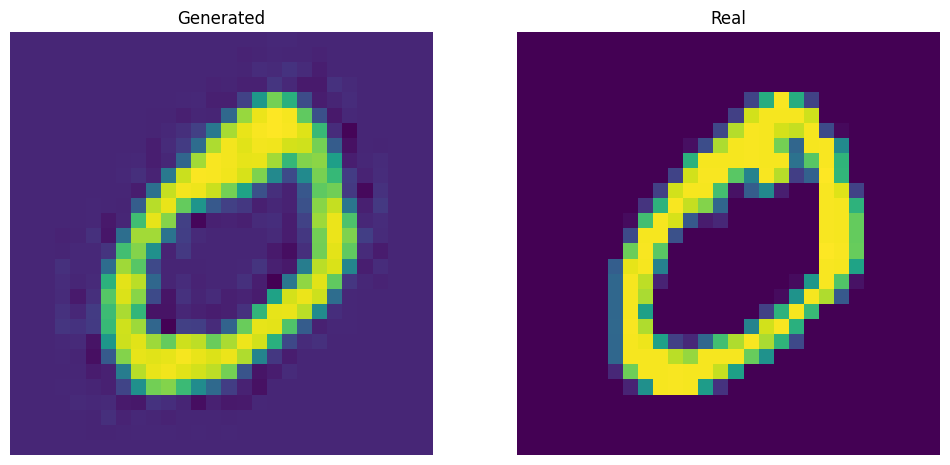

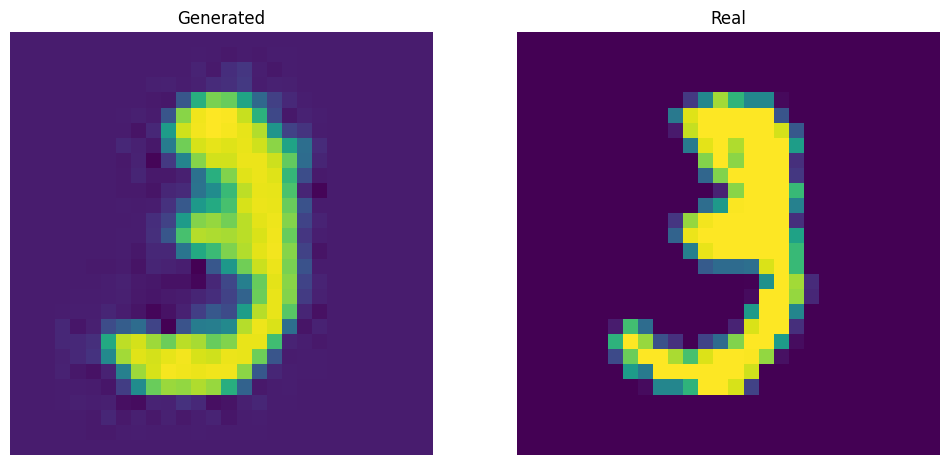

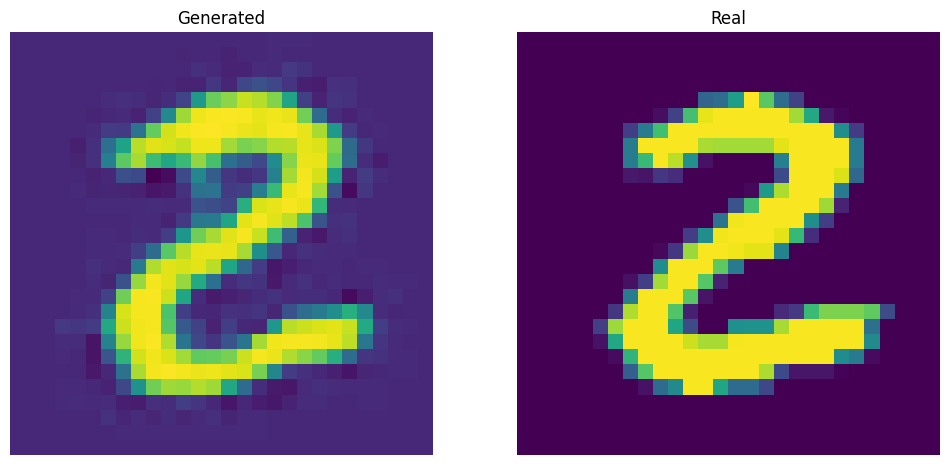

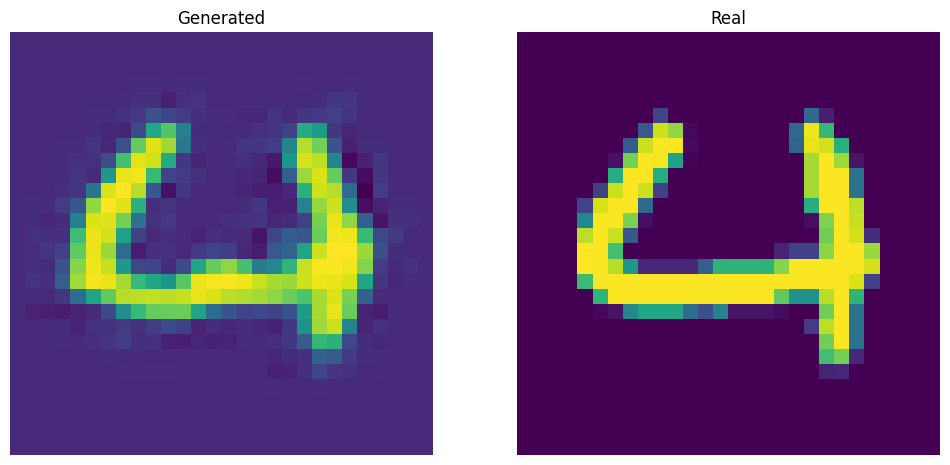

In [12]:
for i in [1, 10, 25, 60]:
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot generated image
    axes[0].imshow(k[0][i])
    axes[0].set_title('Generated')
    axes[0].axis('off')
    
    # Plot real image
    axes[1].imshow(x_train[i])
    axes[1].set_title('Real')
    axes[1].axis('off')
    
    plt.show()